<font size="10" style="font-family: Computer Modern">
Wielowymiarowa iteracyjna metoda Newtona rozwiązywania równań nieliniowych
</font>

In [ ]:
%%bash

cat > requirements.txt <<EOF
contourpy==1.1.1
cycler==0.12.1
fonttools==4.43.1
jax==0.4.13
jaxlib==0.4.13
kiwisolver==1.4.5
matplotlib==3.7.1
ml-dtypes==0.3.1
numpy==1.26.1
opt-einsum==3.3.0
packaging==23.2
Pillow==10.1.0
pyparsing==3.1.1
python-dateutil==2.8.2
scipy==1.11.3
six==1.16.0
EOF

python3 -m pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 95.9 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.4.13-py3-none-any.whl size=1518704 sha256=9d71640a34a3dbb70b0df63175f8b70797de875af00de4dfe7657ce663050bb4
  Stored in directory: /root/.cache/pip/wheels/f3/7a/25/f297f69029b5e4064e4736a0c4b3996a44cc27781c120bcb99
Successfully built jax
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.1 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.1 which is incompatible.


In [ ]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import logging
import random


from jax import jacobian, grad
from abc import ABC, abstractmethod

In [ ]:
logging.getLogger("jax").setLevel(logging.ERROR)
logging.getLogger("matplotlib").setLevel(logging.ERROR)

<font size="9" style="font-family: Computer Modern">
Wielowymiarowa metoda Newtona
</font>

<font size="5" style="font-family: Computer Modern">
    
1.   Wybieramy punkt $x_0 \in \mathbb{R}^n$.
2.   Dla $k = 0, 1, \dots$ kładziemy
$$
    x_{k+1} = x_k - (Df(x_k))^{-1} f(x_k)
$$
</font>

<font size="6" style="font-family: Computer Modern">
Wizualizacja
</font>

In [ ]:
class Newton2dVisualization(ABC):

    def __init__(self, fun, jac):
        self.fun = fun
        self.jac = jac
        self.points = []

        self._colormesh_kwargs = {}
        self._contour_kwargs = {
            'levels': 200,
            'alpha': 0.1,
            'colors': 'white',
            'linewidths': 1.0
        }

        arrowprops = {
            'arrowstyle': '->',
            'mutation_scale': 15,
            'color': 'r',
            'lw': 1
        }

        self._convergence_annotate_kwargs = {
            'arrowprops': arrowprops,
            'va': 'center',
            'ha': 'center'
        }
        self._convergence_scatter_kwargs = {
            's': 30,
            'lw': 0,
            'color': 'deepskyblue',
            'zorder': 1e5,
            'edgecolor': 'black',
            'linewidth': 1
        }


    def plot2d(self,
               ax: mpl.axes.Axes,
               xrange: np.ndarray,
               yrange: np.ndarray,
               contour_levels: int=30,
               limit: float=30.0,
               colorbar: bool=True,
               numpyied: bool=False
               ) -> None:
        """ Visualizes last run of root finding process.

            Args:
                ax (mpl.axes.Axes): matplotlib axes to plot on.
                xrange (jnp.ndarray): 1d array of y values of grid points.
                yrange (jnp.ndarray): 1d array of y values of grid points.
                contour_levels (int): Number of contour levels.
                limit (float): Upper limit for smoothing values.
                colorbar (bool): True if show colorbar.
                numpyied (bool): Can be set to True if function to find root for
                                 can be applied over (2, n) ndarray in numpy fashion.
                                 Using this option can make visualization significantly
                                 faster. If you are not sure, leave it be.
        """

        self.plot_background(ax, xrange, yrange, contour_levels, limit, colorbar, numpyied)
        self.plot_convergence(ax)


    def plot_background(self,
                        ax: mpl.axes.Axes,
                        xrange: np.ndarray,
                        yrange: np.ndarray,
                        contour_levels: int=30,
                        limit: float=30.0,
                        colorbar: bool=True,
                        numpyied: bool=False
                        ) -> None:
        """ Visualizes background - colored contour plot.

            Args:
                ax (mpl.axes.Axes): matplotlib axes to plot on.
                xrange (np.ndarray): 1d array of y values of grid points.
                yrange (np.ndarray): 1d array of y values of grid points.
                contour_levels (int): Number of contour levels.
                limit (float): Upper limit for smoothing values.
                colorbar (bool): True if show colorbar.
                numpyied (bool): Can be set to True if function to find root for
                                 can be applied over (2, n) ndarray in numpy fashion.
                                 Using this option can make visualization significantly
                                 faster. If you are not sure, leave it be.
        """

        grid = np.dstack((np.tile(xrange,(len(yrange), 1)),
                          np.tile(yrange, (len(xrange), 1)).T))
        f_norm_sqr = lambda x : self._euclidean_norm_sqr(self.fun(x))

        if numpyied:
            xss, yss, _ = grid.shape
            gridpoints = grid.T.reshape((2, xss * yss))
            gridvals = f_norm_sqr(gridpoints).reshape((yss, xss)).T
        else:
            gridvals = np.apply_along_axis(f_norm_sqr, axis=2, arr=grid)

        X, Y = np.meshgrid(xrange, yrange)

        if colorbar:
            self._plot_colorbar(ax, gridvals)
        if limit:
            gridvals = self._renormalize(gridvals, vmax=limit)

        ax.pcolormesh(xrange, yrange, gridvals, **self._colormesh_kwargs)
        ax.contour(X, Y, gridvals, **self._contour_kwargs)


    def plot_convergence(self, ax) -> None:
        assert self.points, "Make sure to run root method first"
        for j in range(1, len(self.points)):
            ax.annotate('', xy=self.points[j], xytext=self.points[j-1],
                        **self._convergence_annotate_kwargs)
        ax.scatter(*zip(*self.points), **self._convergence_scatter_kwargs)


    def _plot_colorbar(self, ax, gridvals):
        gridvmin = 0.0
        gridvmax = np.max(gridvals)
        norm = mpl.colors.Normalize(vmin=gridvmin, vmax=gridvmax)
        mappable = mpl.cm.ScalarMappable(norm)
        plt.colorbar(mappable=mappable, ax=ax)


    @staticmethod
    def _renormalize(x: np.ndarray, vmax: float) -> np.ndarray:
        """ Smooth renormalization of function values.

            If function values are too big the plot does not look nicely. Typically
            near the asymptotes the values experience substantial increase by orders
            of magnitude. In such scenario one can't see the details of the function
            shape near the root. To deal with this we iterate logarithmic transformation
            until all function values are not below certain limit.

            Args:
                x (np.ndarray): Array of function values.
                vmax (float): Upper bound for function scaling.
        """
        act_vmax = np.max(x)
        while act_vmax > vmax:
            x = np.log(x + 1)
            act_vmax = np.log(act_vmax)
        return x


    @staticmethod
    def _euclidean_norm_sqr(x: np.ndarray) -> np.ndarray:
        return np.sum(x ** 2, axis=0)


    @abstractmethod
    def root(self, x0: np.ndarray, steps: int) -> np.ndarray:
        pass

<font size="6" style="font-family: Computer Modern">
Implementacja
</font>

In [ ]:
class MultidimensionalNewton(Newton2dVisualization):
    def __init__(self, fun, jac):
        super().__init__(fun, jac)

    def root(self, x0: np.ndarray, steps: int) -> np.ndarray:
        self.points = [x0]

        for _ in range(steps):
            fx0 = self.fun(x0)
            Df = self.jac(x0)
            Df_inv = jnp.linalg.inv(Df)
            x0 = x0 - Df_inv @ fx0
            self.points.append(x0)
        return x0

<font size="9" style="font-family: Computer Modern">
Uogólniona wielowymiarowa metoda Newtona
</font>

<font size="5" style="font-family: Computer Modern">

1.   Wybieramy punkt startowy $x_0 \in \mathbb{R}^n$.
2.   Ciąg $\{x_k\}$ definiujemy rekurencyjnie. Znając wartość $x_k$, wartość $x_{k+1}$ określamy w następujący sposób:
     * ustalamy
$$
d_k = (Df(x_k))^{-1} f(x_k), \quad \gamma_k = \frac{1}{\| (Df(x_k))^{-1} \| \| Df(x_k) \|},
$$
gdzie $h(x) = f(x)^T f(x)$ oraz $h_k(\tau) = h(x_k - \tau d_k)$ i wyznaczamy najmniejszą liczbę całkowitą $j \geq 0$ o takiej własności, że
$$
h_k(2^{-j}) \leq h_k(0) - 2^{-j} \frac{\gamma_k}{4} \|d_k \| \| Dh(x_k) \|.
$$
     * wyznaczamy $\bar{i} \in \{ 0, 1, \dots, j\}$, takie że $h_k(2^{-\bar{i}})$ jest najmniejsze i kładziemy $\lambda_k = 2^{-\bar{i}}$ oraz $x_{k+1} := x_k - \lambda_k d_k$.
</font>

<font size="6" style="font-family: Computer Modern">
Implementacja
</font>

In [ ]:
class GeneralizedNewton(Newton2dVisualization):
    def __init__(self, fun, jac):
        super().__init__(fun, jac)

    def root(self, x0: np.ndarray, steps: int) -> np.ndarray:
        self.points = [x0]
        fx0 = self.fun(x0)
        hx0 = fx0.T @ fx0
        for _ in range(steps):
            Df = self.jac(x0)
            Df_inv = jnp.linalg.inv(Df)

            dk = Df_inv @ fx0

            gk = 1.0 / (jnp.linalg.norm(Df_inv) * jnp.linalg.norm(Df))

            Dh_norm = jnp.linalg.norm(2.0 * fx0.T @ Df)
            dk_norm = jnp.linalg.norm(dk)
            const = 0.25 * gk * dk_norm * Dh_norm

            for j in itertools.count(start=0, step=1):
                power = 0.5 ** j
                fxj = self.fun(x0 - power * dk)
                hxj = fxj.T @ fxj
                if hxj <= hx0 - power * const:
                    break

            x_next = x0
            for i in range(0, j+1):
                xi = x0 - 0.5 ** i * dk
                fxn = self.fun(xi)
                hxn = fxn.T @ fxn
                if hxn < hx0:
                    fx0 = fxn
                    hx0 = hxn
                    x_next = xi
            x0 = x_next
            self.points.append(x0)
        return x0

<font size="8" style="font-family: Computer Modern">
Testy
</font>

<font size="5" style="font-family: Computer Modern">
Poszukiwanie przybliżonego rozwiązania układu równań:

\begin{equation}
  \left\{\begin{array}{@{}l@{}}
    e^x + sin(y) + x + y = -1\\
    \\
    e^x - sin(y) + x - y = 1
  \end{array}\right.\,
\end{equation}
</font>


In [ ]:
f = lambda x: jnp.array([jnp.exp(x[0]) + jnp.sin(x[1]) + x[0] + x[1] + 1, jnp.exp(x[0]) - jnp.sin(x[1]) + x[0] - x[1] - 1], dtype=np.float32)
jac = jacobian(f)
x0 = jnp.array([0,0], dtype=jnp.float32)
steps = 4

gn = GeneralizedNewton(f, jac)

root = gn.root(x0, steps)

print(f'Root:\t\t{root}')
print(f'f(Root):\t{f(root)}')

Root:		[-0.5671433  -0.51097345]
f(Root):	[-1.1920929e-07  0.0000000e+00]


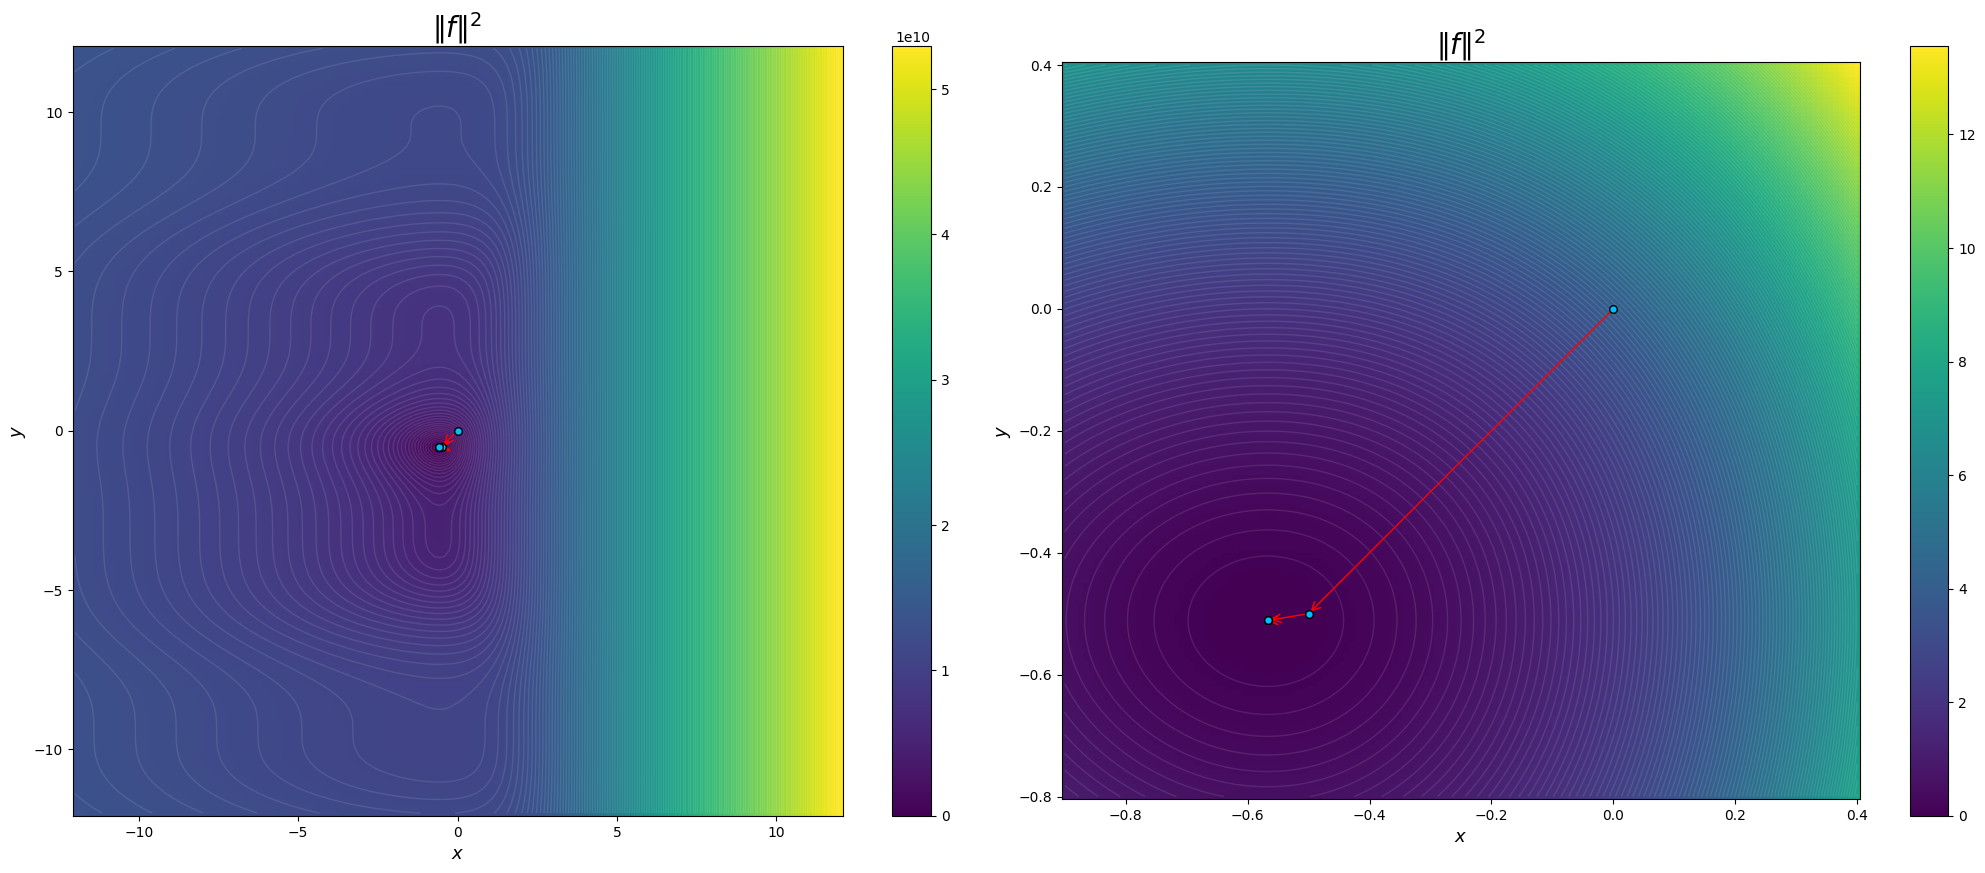

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(26,10), dpi=100)
xrange = np.linspace(-12.0, 12.0, 150)
yrange = np.linspace(-12.0, 12.0, 150)
gn.plot2d(axes[0], xrange, yrange, numpyied=True)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)
axes[0].set_title('$\|f\|^2$', fontdict={'fontsize': 20})

xrange = np.linspace(-0.9, 0.4, 150)
yrange = np.linspace(-0.8, 0.4, 150)
gn.plot2d(axes[1], xrange, yrange, numpyied=True)
axes[1].set_xlabel(r'$x$', fontsize=13)
axes[1].set_ylabel(r'$y$', fontsize=13)
axes[1].set_title('$\|f\|^2$', fontdict={'fontsize': 20})

axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box')
fig.subplots_adjust(wspace=0.02, hspace=0.02);

<font size="5" style="font-family: Computer Modern">
Poszukiwanie przybliżonego rozwiązania układu równań:

\begin{equation}
  \left\{\begin{array}{@{}l@{}}
    x^2 + y^2 = 1\\
    \\
    x + y = 1
  \end{array}\right.\,
\end{equation}
</font>


In [ ]:
f = lambda x: jnp.array([jnp.sum(x**2, axis=0) - 1, jnp.sum(x, axis=0) - 1], dtype=jnp.float32)
jac = lambda x: jnp.array([2 * x,
                           [1, 1]], dtype=jnp.float32)
x0 = jnp.array([3,2], dtype=jnp.float32)
steps = 5

gn = GeneralizedNewton(f, jac)
root = gn.root(x0, steps)

print(f'Root:\t\t{root}')
print(f'f(Root):\t{f(root)}')

Root:		[ 1.0053748  -0.00537475]
f(Root):	[0.01080728 0.        ]


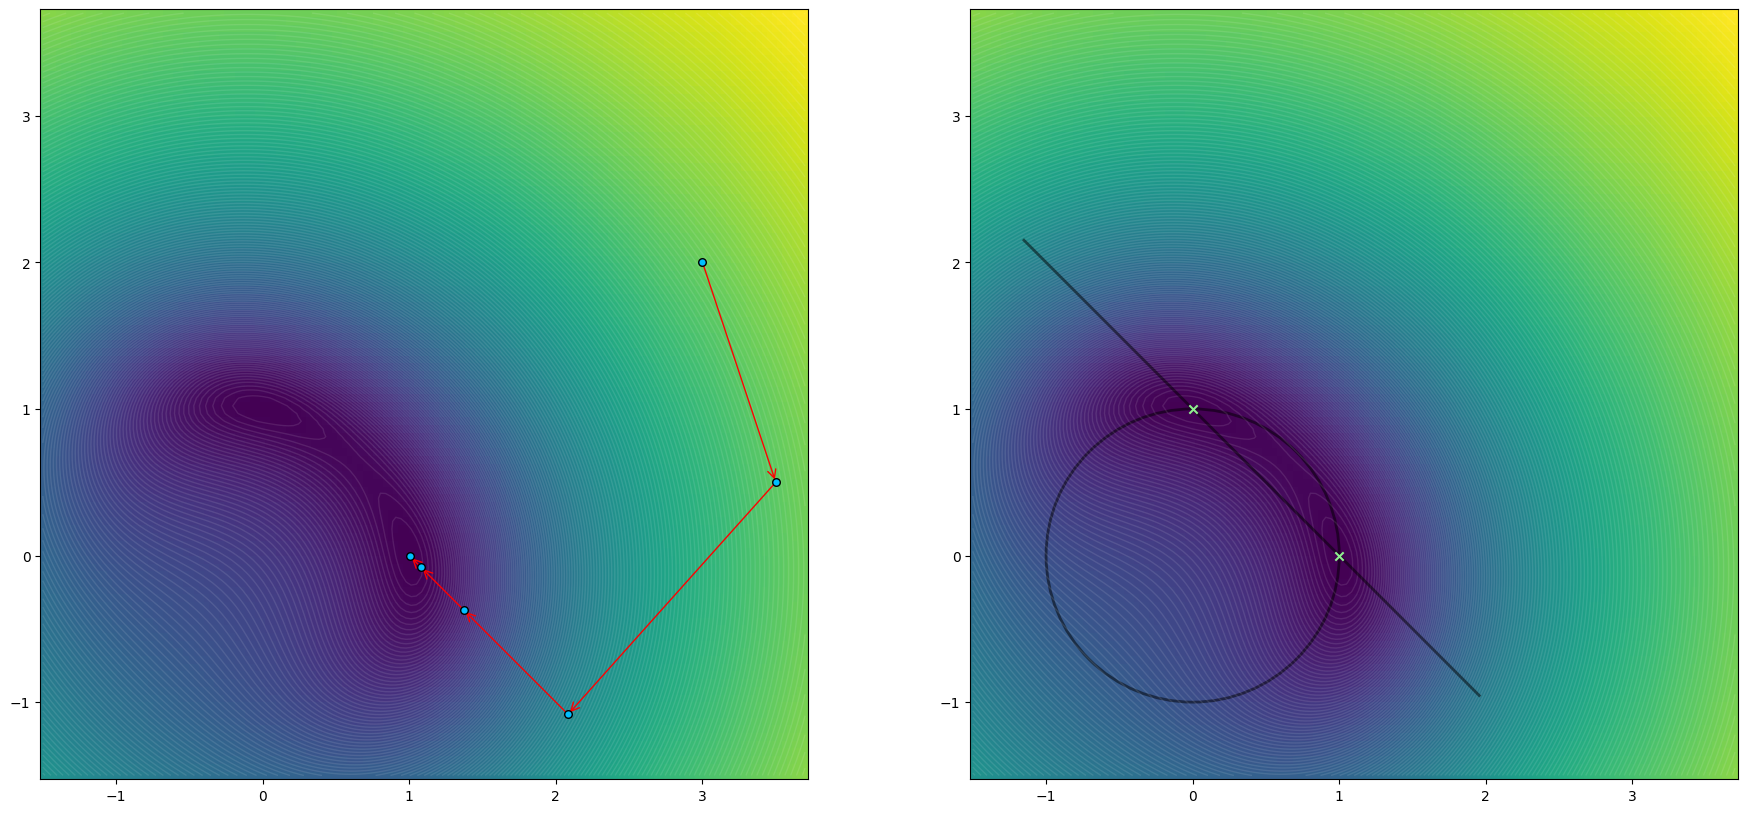

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,10), dpi=100)
xrange = np.linspace(-1.5, 3.7, 150)
yrange = np.linspace(-1.5, 3.7, 100)
gn.plot2d(axes[0], xrange, yrange, colorbar=False, numpyied=True)

gn.plot_background(axes[1], xrange, yrange, colorbar=False, numpyied=True)
axes[1].add_patch(mpl.patches.Circle((0.0, 0.0),
                             radius=1.0,
                             color='k', linewidth=2.0, fill=False, alpha=0.5))
axes[1].scatter([0, 1], [1, 0], zorder=10., marker='x', color='lightgreen')
t = xrange[10: -50]
axes[1].plot(t, 1 - t, color='k', alpha = 0.5, linewidth=2.0);
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box')

<font size="6" style="font-family: Computer Modern">
Minimalizacja
</font>

<font size="5" style="font-family: Computer Modern">
Metody Newtona można użyć w celach optymalizacyjnych. Wówczas dla minimalizacji funkcji skalarnej $f$ szukamy zera jej gradientu $\nabla f$. Nie mamy gwarancji, że ciąg wyznaczony przez metodę zbiegnie do minimum - może nie być zbieżny, zbiegać do maksimum lub do punktu siodłowego. Natomiast w przypadku wypukłej funkcji $f$ (odpowiednio gładkiej i odpowiednio blisko pierwiastka) mamy gwarancję zbieżności.
</font>

<font size="5" style="font-family: Computer Modern">
Dla zobrazowania jakości metody Newtona w optymalizacji użyjemy funkcji Rosenbrock'a. Dla parametrów $a, b \in [0, +\infty)$ jest ona dana wzorem:
$$
f(x,y)=(a-x)^{2}+b(y-x^{2})^{2}
$$
Łatwo widać, że posiada ona minimum globalne w punkcie $(x, y) = (a, a^2)$, dla którego $f(x,y)=0$.
W oryginalnym artykule [1], w którym funkcja ta się pojawia, rozważane są parametry $a = 1, b = 100$.
</font>

[1] An Automatic Method for Finding the Greatest or Least Value of a Function
H. H. Rosenbrock
The Computer Journal, Volume 3, Issue 3, 1960, Pages 175–184, https://doi.org/10.1093/comjnl/3.3.175

In [ ]:
def rosenbrock(a, b):
    return lambda x: (1 - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2

In [ ]:
f = rosenbrock(a=1.0, b=10.0)
df = grad(f)
jac = jacobian(df)
x0 = jnp.array([1.5,1.5], dtype=jnp.float32)
steps = 13

gn = GeneralizedNewton(df, jac)

gn.root(x0, steps)

Array([1.0000172, 1.0000261], dtype=float32)

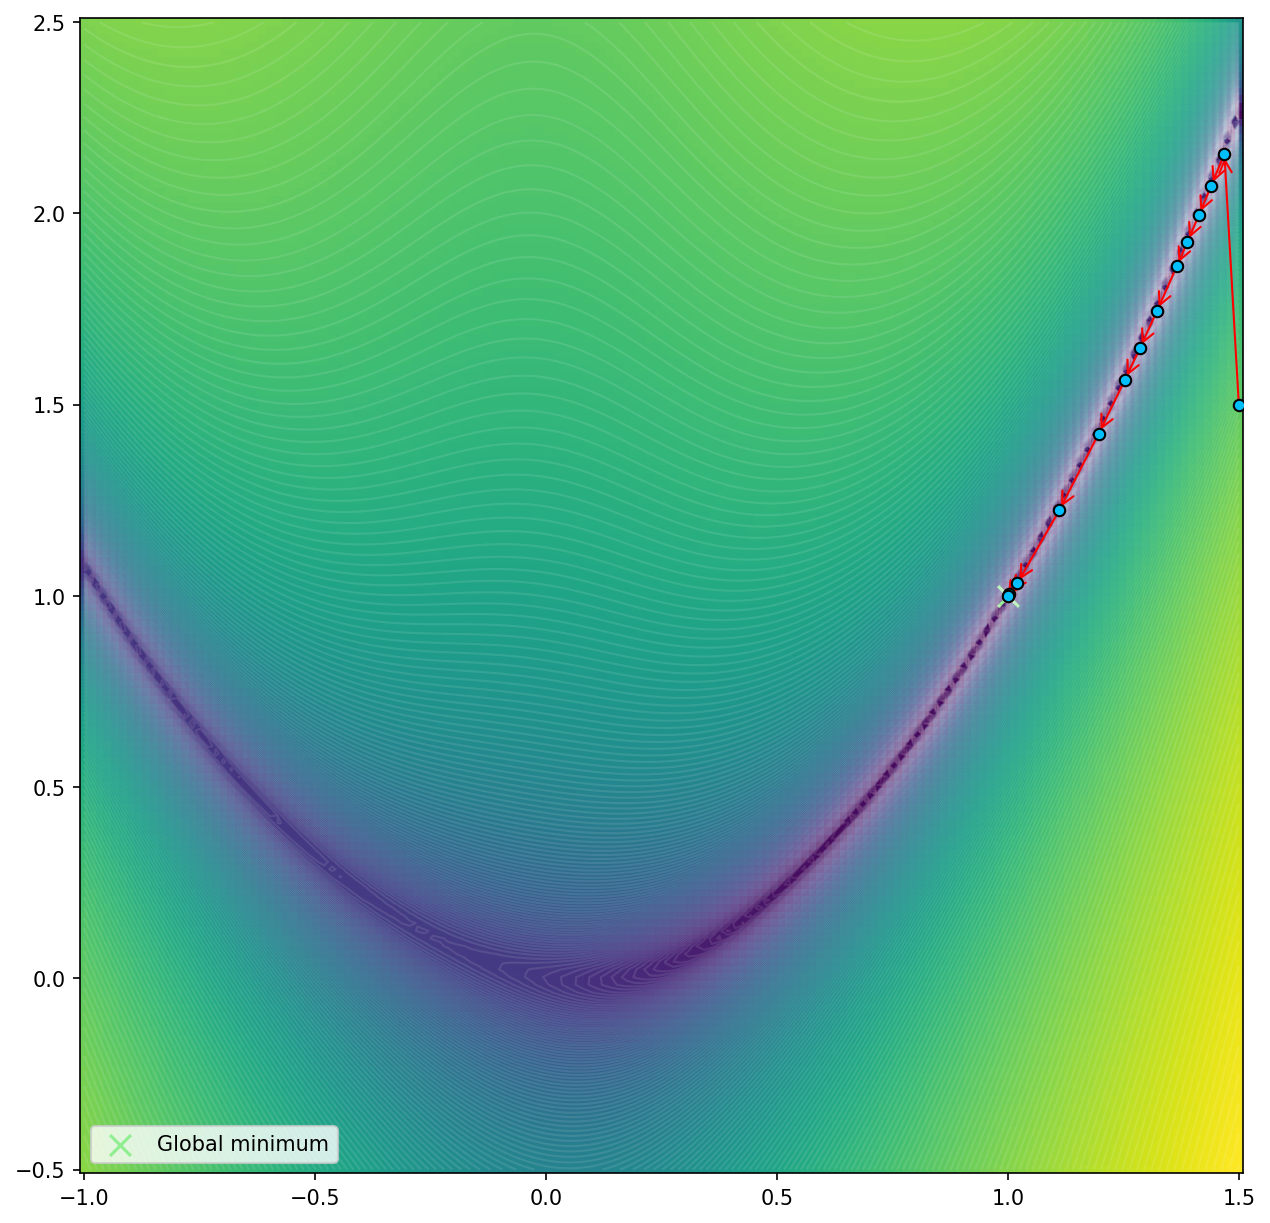

In [ ]:
xrange = np.linspace(-1.0, 1.5, 150)
yrange = np.linspace(-0.5, 2.5, 150)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), dpi=150)
gn.plot2d(ax, xrange, yrange, colorbar=False)
ax.scatter([1], [1], color='lightgreen', marker='x', s=100, label='Global minimum');
ax.legend(loc='lower left');

<font size="5" style="font-family: Computer Modern">
    
Dla $a = 1, b = 10$ udaje się zbliżyć do globalnego minimum w punkcie $(1, 1)$ względnie szybko.
</font>

In [ ]:
f = rosenbrock(a=1.0, b=100.0)
df = grad(f)
jac = jacobian(df)
x0 = jnp.array([1.5,1.5], dtype=jnp.float32)
steps = 50

gn = GeneralizedNewton(df, jac)

gn.root(x0, steps)

Array([1.3788776, 1.9010277], dtype=float32)

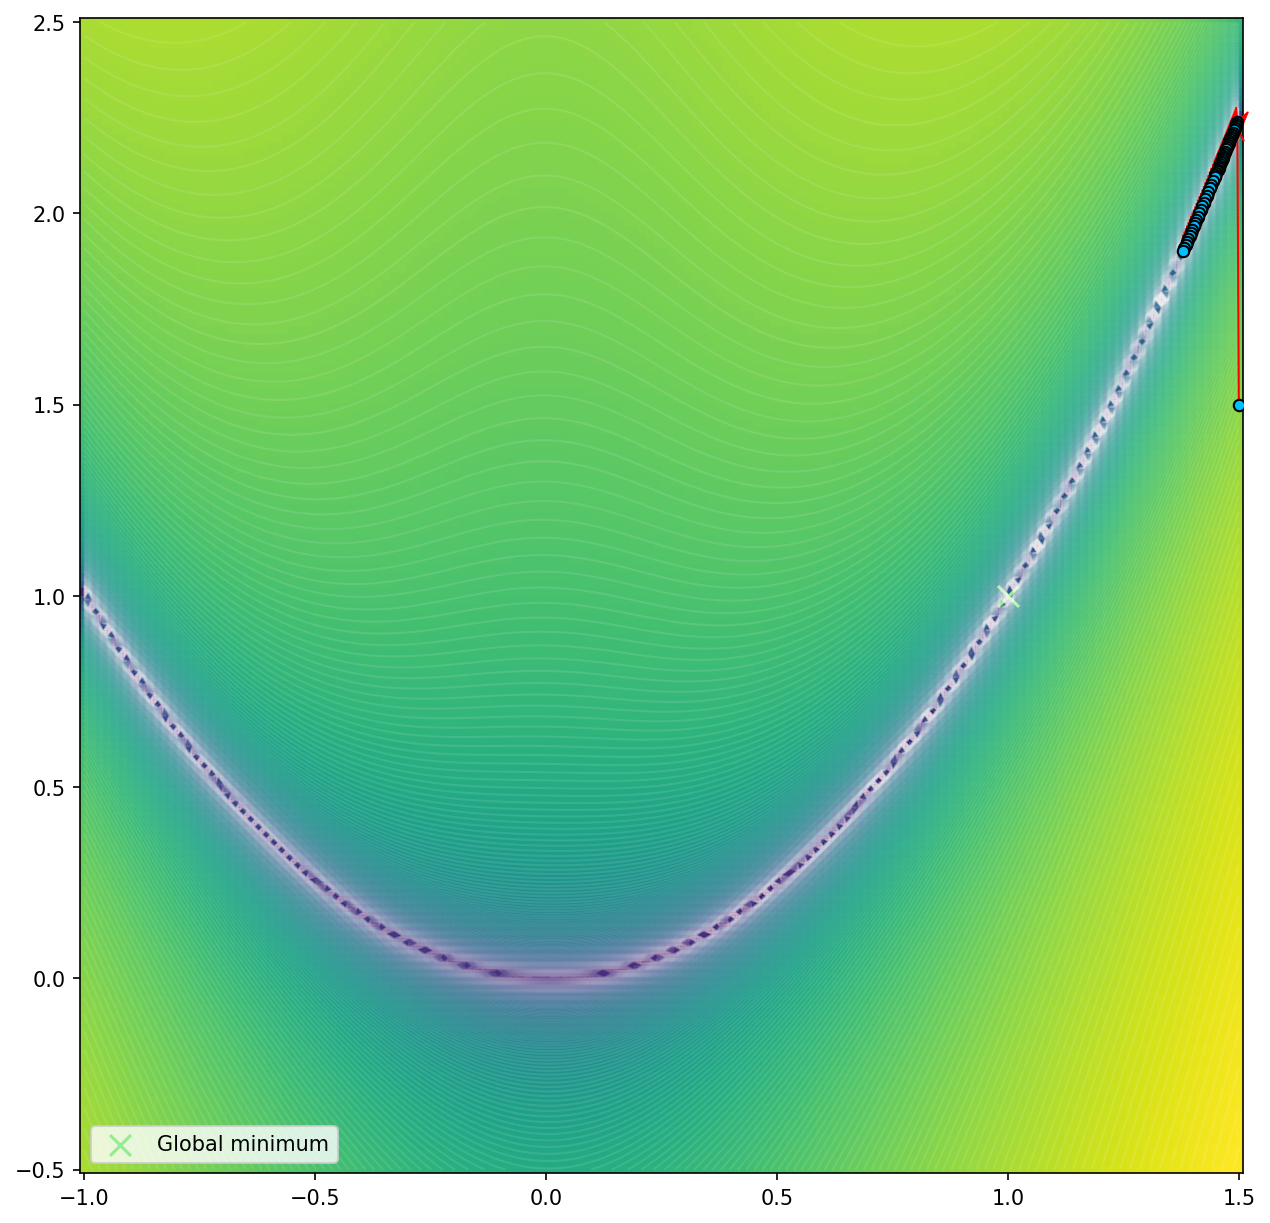

In [ ]:
xrange = np.linspace(-1.0, 1.5, 150)
yrange = np.linspace(-0.5, 2.5, 150)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), dpi=150)
gn.plot2d(ax, xrange, yrange, colorbar=False)
ax.scatter([1], [1], color='lightgreen', marker='x', s=100, label='Global minimum');
ax.legend(loc='lower left');

<font size="5" style="font-family: Computer Modern">
    
Dla $a = 1, b = 100$ można zaobserwować bardzo powolne zmierzanie przubliżenia w kierunku punktu $(1, 1)$. Wpadamy do u-kształtnej doliny, wzdłuż której małymi kroczkami przesuwamy się w kierunku minimum.
</font>

<font size="6" style="font-family: Computer Modern">
Dopasowanie krzywej
</font>

<font size="5" style="font-family: Computer Modern">
Posiadając narzędzie do minimalizacji, możemy rozwiązać wiele praktycznych problemów. Jednym z nich jest dopasowanie krzywej do zaszumionych danych.
</font>

<font size="5" style="font-family: Computer Modern">
Poniżej próbkujemy wartości wielomianu $x^4 - x^3 + 3x^2 + 2x + 0,2$ w 50 punktach z przedziału $[-1, 1]$ a następnie dodajemy do tych próbek szum normalny. Następnie losujemy punkt z $[-3, 3]^5$, który koduje współrzędne wielomianu będącego początkowym przybliżeniem wielomianu wyjściowego. Kolejnym krokiem jest użycie metody Newtona do zminimalizowania funkcji kosztu, którą jest błąd średniokwadratowy między wartościami wielomianu przybliżającego a zaszumionymi danymi w punktach próbkowania.
</font>

In [ ]:
class Polynomial:
    def __init__(self, p: list[complex]):
        self.p = np.array(p)

    def __call__(self, x: complex):
        return self._horner(x)

    def _horner(self, x: complex):
        res = 0.0
        for i in range(len(self.p)):
            res = res * x + self.p[i]
        return res

In [ ]:
random.seed(321)
np.random.seed(321)
f = Polynomial([1.0, -1.0, 3.0, 2.0, 0.2])

x = np.linspace(-1.0, 1.0, 50)
XS = np.array([x**4, x**3, x**2, x, 0*x + 1])
fs = f(x)
fnoise = fs + np.random.normal(0, 0.2, fs.shape)
initial_coeffs = np.random.uniform(-3.0, 3.0, size=5)
initial_coeffs

array([ 1.26757405,  0.09384024, -1.02904642,  0.71247628,  1.97063744])

In [ ]:
def mse(coeffs):
    return 0.5 * jnp.mean((fnoise - coeffs @ XS) ** 2, axis=-1)
dmse = grad(mse)
jac = jacobian(dmse)
steps = 1

gn = GeneralizedNewton(dmse, jac)
coeffs = gn.root(initial_coeffs, steps)
coeffs

Array([ 1.0850456 , -1.1514306 ,  2.9487724 ,  2.0997858 ,  0.15984285],      dtype=float32)

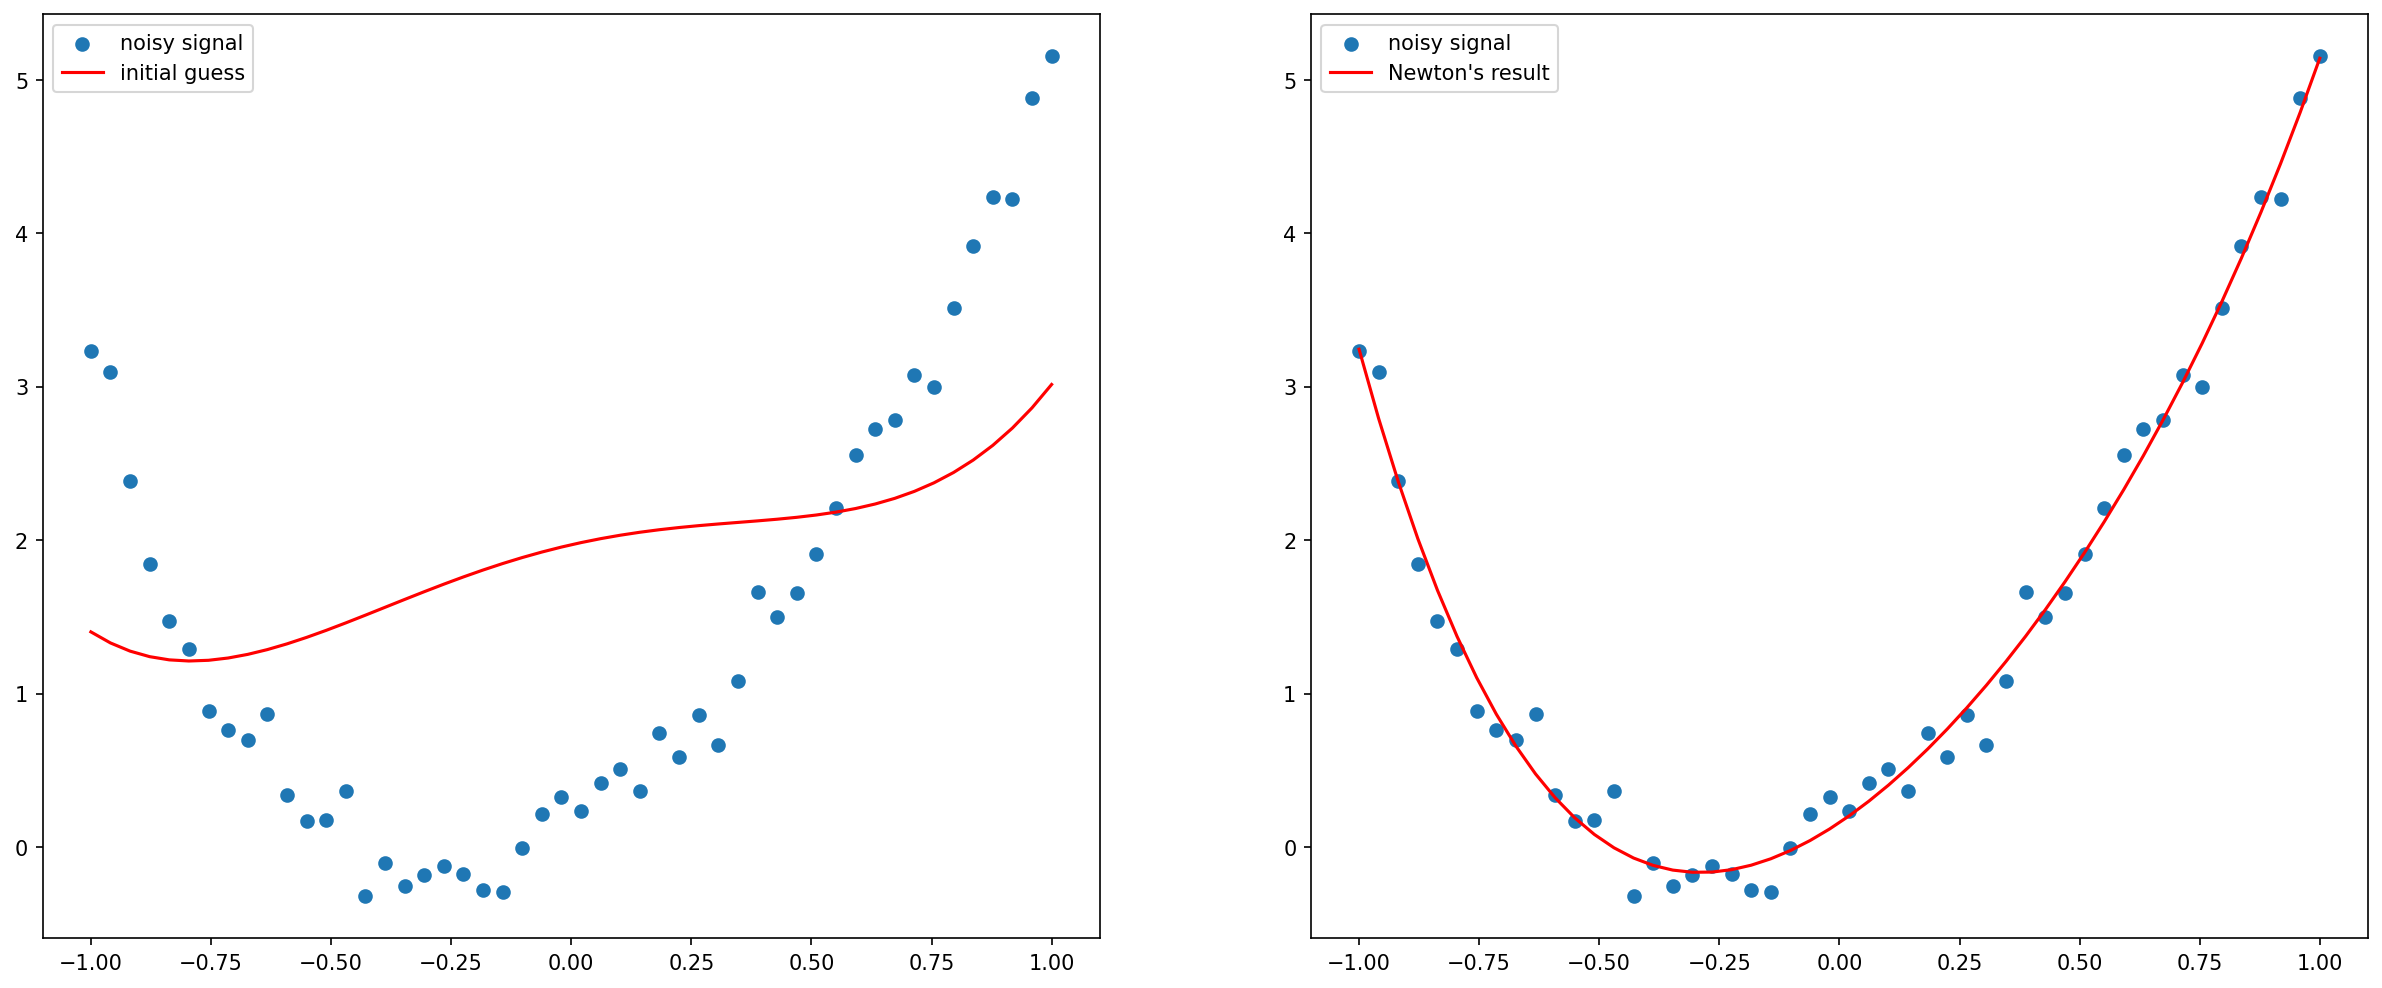

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), dpi=150)

axes[0].scatter(x, fnoise, label='noisy signal')
axes[0].plot(x, initial_coeffs @ XS, color='red', label='initial guess')
axes[0].legend();

axes[1].scatter(x, fnoise, label='noisy signal')
axes[1].plot(x, coeffs @ XS, color='red', label='Newton\'s result')
axes[1].legend();